In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import warnings
from sklearn.metrics import precision_score, recall_score,f1_score

In [5]:
def dataprep():
    # Paso 1: Cargar los datos.
    df = pd.read_csv('bank.csv')

    # Paso 2: Definir las columnas categóricas.
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

    # Convertir la columna 'deposit' a binaria
    df['deposit'] = pd.Categorical(df['deposit']).codes

    # Paso 3: Codificar las columnas categóricas con get_dummies
    df = pd.get_dummies(df, columns=categorical_cols)

    # Paso 4: Dividir los datos en características (X) y etiquetas (y), y luego en conjuntos de entrenamiento y evaluación.
    X = df.drop('deposit', axis=1)
    y = df['deposit']

    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, stratify=y_valtest, random_state=42)

    # Paso 5: Normalizar los datos de entrenamiento y aplicar la misma transformación a los datos de prueba.
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test, X_val, y_val 


In [ ]:
"""
Con el siguiente código lo que se intenta es buscar la mejor configuración de los hiperparámetros que se van a utilizar en XGBoost
"""
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

X_train, y_train, X_test, y_test, X_val, y_val = dataprep()

print('Conjunto de entrenamiento: ', X_train.shape)
print('Conjunto de validación: ', X_val.shape)
print('Conjunto de prueba: ', X_test.shape)

# Creamos el modelo con las distintas combinaciones de los parámetros y entrenamos el modelo
max_depth_values = np.linspace(8, 40, 10) #establece la profundida de los árboles
learning_rate_values = np.linspace(0.005, 0.1, 10)
subsample_values = np.linspace(0.2, 1, 10)

max_model_accuracy = 0
best_max_depth = 0
best_learning_rate = 0
best_subsample = 0

# Iteramos sobre cada combinación de hiperparámetros
for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        for subsample in subsample_values:
            model = XGBClassifier(max_depth=int(max_depth), learning_rate=learning_rate, subsample=subsample, verbosity=0)
            model.fit(X_train, y_train)
            accuracy = model.score(X_val, y_val) #Validamos el modelo
            if accuracy > max_model_accuracy: #selección de los mejores parámetros
                max_model_accuracy = accuracy
                best_max_depth = max_depth
                best_learning_rate = learning_rate
                best_subsample = subsample


Conjunto de entrenamiento:  (6697, 51)
Conjunto de validación:  (2232, 51)
Conjunto de prueba:  (2233, 51)


En el apartado anterior se ha definido 3 hiperparámetros para nuestro modelo que son max_depth_values, learning_rates_values y subsample_values, posteriormente se ha establecido para cada hiperparámetro, 10 valores distintos.

A continuación se ha entrenado un modelo disntinto para cada configuración de los hiperparáemtros y se ha realizado su correspondiente validación, obteniendo con ello la mejor configuración.


In [ ]:
max_model_accuracy, best_max_depth, best_learning_rate, best_subsample

(0.6191756272401434, 12, 0.01, 1.0)

In [6]:
def plot_precision_recall(precision_test, recall_test):
    plt.figure(figsize=(15, 6))

    # Gráfico para el conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.barh(['Precision', 'Recall'], [precision_test, recall_test], color=['#1f77b4', '#ff7f0e'])
    plt.xlabel('Score')
    plt.title('Test Data')

    plt.tight_layout() 
    plt.show()


Valor de las etiquetas de test     10884    0
3453     1
4661     1
1287     1
1959     1
        ..
10464    0
6896     0
6503     0
9162     0
9990     0
Name: deposit, Length: 2233, dtype: int8
La predicción de los datos de test [0 1 1 ... 0 0 0]
El porcentaje de aciertos en los datos de test 0.8378862516793552
Recall y precisión de test:  0.8506616257088847  y  0.8152173913043478
Medida F1 de test:  0.8325624421831638


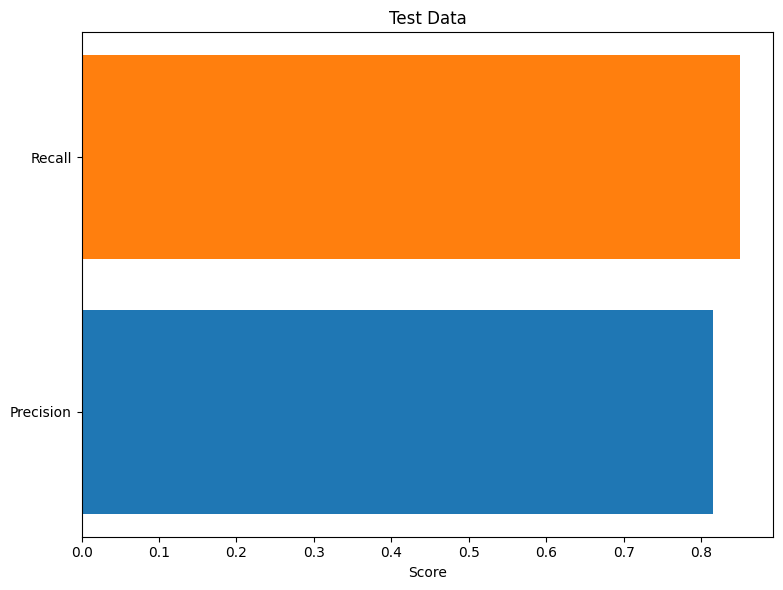

In [7]:
"""
Definimos un nuevo modelo con la mejor configuración obtenida en el apartado anterior y mostramos el resultado que se obtiene
"""
best_max_depth, best_learning_rate, best_subsample = (12, 0.01, 1.0)
X_train, y_train, X_test, y_test, X_val, y_val = dataprep()

model = XGBClassifier(max_depth=best_max_depth, learning_rate=best_learning_rate, subsample=best_subsample, verbosity=0)
model.fit(X_train, y_train, verbose=0)
y_pred = model.predict(X_test)
test_accuracy = model.score(X_test, y_test)
print("Valor de las etiquetas de test    ", y_test)
print("La predicción de los datos de test", y_pred)
print("El porcentaje de aciertos en los datos de test", test_accuracy)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

print("Recall y precisión de test: ", recall_test, " y ", precision_test)
print("Medida F1 de test: ", f1_test)

plot_precision_recall(precision_test, recall_test)


Finalmente, se ha entrenado de nuevo todo el modelo con los hiperparámetros obtenidos anteriormente. Se muestra las distintas métricas para este modelo y se observa que tiene una precisión entorno al 84%.